# Reduction, Analysis and Visualization of *in situ* UV-Vis Absorbance

In this notebook, we'll get a taste for data I/O, high-throughput analysis and visualization with pandas (and numpy, and matplotlib) by considering the example of *in situ* UV-Vis absorbance spectra collected while blade-coating a solution of the semiconducting polymer DPP-DTT in chloronapthalene.

UV-Vis spectra were collected with parallel and perpendicular polarization (relative to the coating direction) simultaneously, at 50 ms intervals. We would like to plot both polarized spectra over time, calculate the anisotropy of the film (a function of the ratio between the polarized absorbances), and maybe even make a real-time movie of the spectral evolution.

# Table of Contents <a name="contents"></a>

## [0. Building a Database](#init)
> ### [0.0 Traversing Directories](#glob)
> ### [0.1 Parsing Filenames](#parsing)
> ### [0.2 Syncing Time](#time)
> ### [0.3 Summary](#summ0)

## [1. Raw Data](#raw)
> ### [1.0 File I/O](#io)
> ### [1.1 Let's PLOT](#plot)

# 0. Building a Database <a name='init'></a>
[Back to TOC](#contents)

The initial approach is always very similar no matter what project I'm working on: get a list of all the files you care about, and load them into a DataFrame.

Traversing folders and files is relatively straightforward in Python. I use a combination of [os](https://docs.python.org/3/library/os.html) and [glob](https://docs.python.org/3/library/glob.html) for the most common tasks, but [pathlib](https://docs.python.org/3/library/pathlib.html) is a good option, too.

## 0.0 Traversing Directories <a name='glob'></a>

In [58]:
from os.path import join, split
from glob import glob
data_folder = 'data/UV/181120_dpp_cn10_v25/' # Hint: you can use tab-completion for file paths in the Notebook

In [74]:
glob(join(data_folder, '*/*.txt'))[:5]

['data/UV/181120_dpp_cn10_v25/para/para_00000.txt',
 'data/UV/181120_dpp_cn10_v25/para/para_00001.txt',
 'data/UV/181120_dpp_cn10_v25/para/para_00002.txt',
 'data/UV/181120_dpp_cn10_v25/para/para_00003.txt',
 'data/UV/181120_dpp_cn10_v25/para/para_00004.txt']

### A few things here:
* `join()` is a method for combining folder and file paths that automatically puts in the correct / or \
* `glob()` takes a file path with wildcards (* = string of any length with any characters) and returns all matching files
* Thus, `glob(data_folder/*/*.txt)` will return all .txt files within any subdirectory of data_folder

### Big hint for Jupyter: if you place your cursor inside the ( ) of a method call, and hit <kbd>Shift</kbd>+<kbd>Tab</kbd>, a handy tip will tell you the arguments that method expects
* If you try this for a method on an object, the object must have been defined already (cell must have been run)
* Try it on `join(  )`

### Now we'll import pandas, and make this file list the first column of our DataFrame

In [11]:
import pandas as pd

# Instantiate an empty DataFrame
df = pd.DataFrame()

# Pass the list from glob into a column of df called 'path'
df['path'] = glob(join(data_folder, '*/*.txt'))

# Return four random rows from df
df.sample(4)

,path
537,data/UV/181120_dpp_cn10_v25/para/para_00537.txt
858,data/UV/181120_dpp_cn10_v25/perp/perp_00098.txt
1291,data/UV/181120_dpp_cn10_v25/perp/perp_00531.txt
929,data/UV/181120_dpp_cn10_v25/perp/perp_00169.txt


`df.sample(n)` is a great way to check that your code worked as expected without displaying the entire DataFrame.

## 0.1 Parsing Filenames <a name='parsing'></a>
[Back to TOC](#contents)

### There are clearly two groups here: para and perp.

We could make two separate DataFrames, like `df_para` and `df_perp`, but that defeats the purpose of pandas. In pandas, we keep all of the data in one master DataFrame, and add columns to identify groups and other metadata. We can easily query and slice by these groups later on.

### I will use `os.path.split()` (imported above as `split`) to grab the 'para' or 'perp' folder and put it in a new column

We will leverage the `.apply()` method for this.

In [17]:
# Using the os.path methods are safer here than doing str.split('/') because that's OS-specific
df['pol'] = df['path'].apply(lambda p: split(split(p)[0])[1])

df.sample(6)

,path,pol
448,data/UV/181120_dpp_cn10_v25/para/para_00448.txt,para
403,data/UV/181120_dpp_cn10_v25/para/para_00403.txt,para
195,data/UV/181120_dpp_cn10_v25/para/para_00195.txt,para
277,data/UV/181120_dpp_cn10_v25/para/para_00277.txt,para
198,data/UV/181120_dpp_cn10_v25/para/para_00198.txt,para
75,data/UV/181120_dpp_cn10_v25/para/para_00075.txt,para


### I can also make a column for the five-digit identifier for each file

I'll use a list comprehension here just to show some variety; you can pass `list` objects to make new columns!

In [24]:
df['id'] = [int(path[-9:-4]) for path in df['path']] # The 'int' is crucial here for sorting purposes
df.sample(4)

,path,pol,id
152,data/UV/181120_dpp_cn10_v25/para/para_00152.txt,para,152
1326,data/UV/181120_dpp_cn10_v25/perp/perp_00566.txt,perp,566
1374,data/UV/181120_dpp_cn10_v25/perp/perp_00614.txt,perp,614
116,data/UV/181120_dpp_cn10_v25/para/para_00116.txt,para,116


You could imagine parsing out very complicated filenames using simple combinations of `str` methods, `os` methods and `.apply()`

`re` (regexp) is also very common at this stage.

## 0.2 Syncing Time <a name='time'></a>
[Back to TOC](#contents)

### We need to set the time scale for the para and perp files
They should have been saved simultaneously, so there should be the same number of each. In theory, I ran collection for 180s at 50ms intervals, but sometimes the SpectraSuite software doesn't save as often as it says.

In [25]:
print('Should be {} files from each channel'.format(180/0.05))

Should be 3600.0 files from each channel


Remember `df.groupby()`? We can use that here and aggregate by 'max' to get the highest file ID (number of files)

In [29]:
df.groupby('pol').agg('max')

,path,id
pol,,
para,data/UV/181120_dpp_cn10_v25/para/para_00759.txt,759
perp,data/UV/181120_dpp_cn10_v25/perp/perp_00759.txt,759


So there are 760 of each channel. That's fine, but I honestly don't remember what my collection settings were. We can use `os` again to get the date modified and find the approximate collection time and interval.

In [31]:
from os.path import getmtime
print('{} was last modified at {}'.format(df['path'].iloc[0], getmtime(df['path'].iloc[0])))

data/UV/181120_dpp_cn10_v25/para/para_00000.txt was last modified at 1542741656.0


Apparently the os is reporting this in units of "seconds since the start of the universe". We should just set the earliest modified file to be t=0.

In [38]:
df['mod_time'] = df['path'].apply(getmtime)
df['mod_time'] = df['mod_time'] - df['mod_time'].min()
df.iloc[:4]

,path,pol,id,mod_time
0,data/UV/181120_dpp_cn10_v25/para/para_00000.txt,para,0,0.0
1,data/UV/181120_dpp_cn10_v25/para/para_00001.txt,para,1,0.0
2,data/UV/181120_dpp_cn10_v25/para/para_00002.txt,para,2,0.0
3,data/UV/181120_dpp_cn10_v25/para/para_00003.txt,para,3,0.0


### We need millisecond precision, but this is only to the nearest second, apparently

This is overkill, but a neat way to flex our panda muscles. I'll bet in one line, I can (confidently) estimate how many milliseconds each file represents. How would you do this?

In [50]:
df.groupby(['pol','mod_time']).count().agg(['mean','std'])

,path,id
mean,10.0,10.0
std,0.0,0.0


There's a lot going on in that line, so let's parse it out:
* `df.groupby(['pol','mod_time'])` this is a multi-level groupby, which will group by the polarization, then by the mod times
* `.count()` this will just count how many entries there are for each of these groups: for each polarization at each unique mod_time, how many files are there?
* `.agg(['mean','std'])` this calculates statistics for the file counts over both polarizations and all mod_times.

What I'm looking for is: how many files are saved each second (each mod_time)? Is there any spread to that? This is telling me: the mean is 10, and the std is 0, so each second, 10 files are saved, and that does not vary over the whole run.

### The time interval is thus 100 ms

Let's make that a new column called 't' based on the file ID.

In [54]:
df['t'] = df['id']*0.1 # This is why it was important to have id as an int-type
df.sort_values(['pol','t']).head()

,path,pol,id,mod_time,t
0,data/UV/181120_dpp_cn10_v25/para/para_00000.txt,para,0,0.0,0.0
1,data/UV/181120_dpp_cn10_v25/para/para_00001.txt,para,1,0.0,0.1
2,data/UV/181120_dpp_cn10_v25/para/para_00002.txt,para,2,0.0,0.2
3,data/UV/181120_dpp_cn10_v25/para/para_00003.txt,para,3,0.0,0.3
4,data/UV/181120_dpp_cn10_v25/para/para_00004.txt,para,4,0.0,0.4


## 0.3 Summary <a name='summ0'></a>
[Back to TOC](#contents)

In summary, we can make a database for the experimental files in a handful of lines of clean pandas code:

In [57]:
df = pd.DataFrame()

# Column for file paths
df['path'] = glob(join(data_folder, '*/*.txt'))

# Column for polarizations
df['pol'] = df['path'].apply(lambda p: split(split(p)[0])[1])

# Column for file IDs
df['id'] = [int(path[-9:-4]) for path in df['path']]

# Column for file modification times
df['mod_time'] = df['path'].apply(getmtime)
df['mod_time'] = df['mod_time'] - df['mod_time'].min()

# Column for actual acquisition times
df['t'] = df['id']*0.1

df.head()

,path,pol,id,mod_time,t
0,data/UV/181120_dpp_cn10_v25/para/para_00000.txt,para,0,0.0,0.0
1,data/UV/181120_dpp_cn10_v25/para/para_00001.txt,para,1,0.0,0.1
2,data/UV/181120_dpp_cn10_v25/para/para_00002.txt,para,2,0.0,0.2
3,data/UV/181120_dpp_cn10_v25/para/para_00003.txt,para,3,0.0,0.3
4,data/UV/181120_dpp_cn10_v25/para/para_00004.txt,para,4,0.0,0.4


# 1. Raw Data <a name='raw'></a>

## 1.0 File I/O <a name='io'></a>
[Back to TOC](#contents)

Let's take a look at one of these files. Numpy and pandas both have txt-readers, and we're going to have to import numpy eventually, so we'll do that. Let's time each one to see which is faster.

In [62]:
import numpy as np

In [63]:
%timeit np.loadtxt(df['path'][0], skiprows=17, comments='>')

9.86 ms ± 316 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [68]:
%timeit pd.read_csv(df['path'][0], sep='\t', skiprows=17, comment='>', names=['wl','abs'])

1.39 ms ± 10.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Wow, pandas is much more optimized than I thought. That's good, because *we want to load spectra into DataFrames anyway.*

In [69]:
spec = pd.read_csv(df['path'][0], sep='\t', skiprows=17, comment='>', names=['wl','abs'])
spec.head()

,wl,abs
0,189.04,-0.336
1,189.51,-0.000
2,189.98,-0.000
3,190.45,-0.000
4,190.92,-0.000


Feel free to read more about `pd.read_csv()`; it is very versatile. I had to open the raw file to figure out `skiprows`, `comment`, etc., but that's really all. I passed `['wl','abs']` as `names` to give the columns names.

## 1.1 Let's PLOT <a name='plot'></a>
[Back to TOC](#contents)

There are an ever-growing number of ways to generate good-looking data visualizations in the Notebook. For scientific data, you won't find a more fully-featured library than [matplotlib](https://matplotlib.org/), and I would be remiss not to mention its handy and beautiful extension, [seaborn](https://seaborn.pydata.org/).

In [72]:
from matplotlib import pyplot as plt
plt.style.use('seaborn')

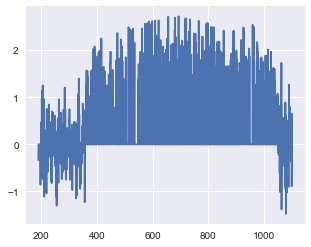

In [73]:
plt.figure(figsize=(5,4))
plt.plot(spec['wl'], spec['abs'])

In [60]:
np.loadtxt(df['path'][0], skiprows=17, comments='>')

NameError: name 'np' is not defined

### Import python libraries

In [1]:
# numpy and plotting
import numpy as np
from scipy.signal import convolve2d, medfilt
import matplotlib as mpl
import matplotlib.pyplot as plt

# Data handling
import os
import glob
import pandas as pd

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True,
                 'xtick.top': True,
                 'xtick.direction': 'in',
                 'ytick.right': True,
                 'ytick.direction': 'in',
                 'font.sans-serif': 'Arial',
                 'font.size': 14
                })
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.dpi'] = 96

## UV

In [2]:
base_folder = "F:\\N2200 Project\\data\\nist\\uv"
# run_name = "180727_n22tol20_solution_slide"
run_name = "180727_n22tol20_nogr_v5_insitu_3"
run_time = 180  # how many seconds was the total run
uv_straight = glob.glob(os.path.join(base_folder,run_name,"straight","*.txt".format(run_name)))
uv_kicked = glob.glob(os.path.join(base_folder,run_name,"kicked","*.txt".format(run_name)))

figfolder = os.path.join(base_folder,run_name,"movie")
os.makedirs(os.path.join(figfolder,'raw_waxs'),exist_ok=True)
os.makedirs(os.path.join(figfolder,'raw_uv'),exist_ok=True)

print(uv_straight[0])
print(uv_kicked[0])

F:\N2200 Project\data\nist\uv\180727_n22tol20_nogr_v5_insitu_3\straight\straight_00000.txt
F:\N2200 Project\data\nist\uv\180727_n22tol20_nogr_v5_insitu_3\kicked\kicked_00000.txt


In [3]:
straight0 = np.loadtxt(uv_straight[0], skiprows=17, comments='>')
waves = straight0[:,0]
straight_raw = np.array([np.transpose(np.loadtxt(tt,skiprows=17,comments='>')[:,1]) for tt in uv_straight])
straight_raw.shape

(880, 2048)

In [4]:
kicked_raw = np.array([np.transpose(np.loadtxt(tt,skiprows=17,comments='>')[:,1]) for tt in uv_kicked])
kicked_raw.shape

(880, 2048)

In [5]:
uv_dt = 60 / 293
print('{} seconds between each file save'.format(uv_dt))

0.20477815699658702 seconds between each file save


In [6]:
straight_array = np.array([medfilt(row, kernel_size=5) for row in straight_raw])
kicked_array = np.array([medfilt(row, kernel_size=5) for row in kicked_raw])

### Plot example spectra

<IPython.core.display.Javascript object>


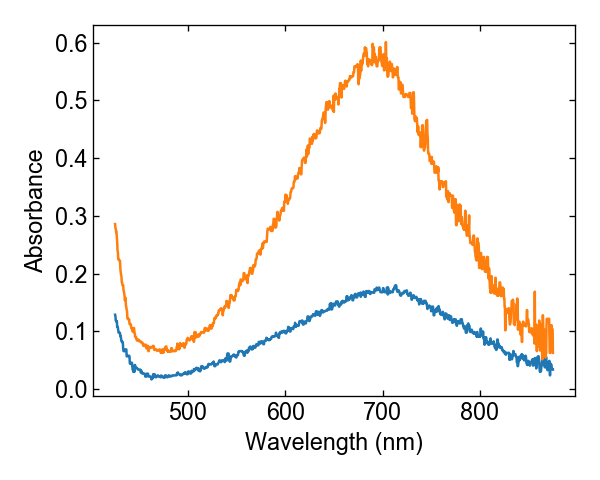

In [7]:
%matplotlib notebook

w_start = 425; w_stop = 875
w_start_ind = np.where(waves>w_start)[0][0]
w_stop_ind = np.where(waves>w_stop)[0][0]
waves_crop = waves[w_start_ind:w_stop_ind]

which_row = 201

plt.figure(figsize=(5,4))
plt.plot(waves_crop,straight_array[which_row,w_start_ind:w_stop_ind],
         waves_crop,kicked_array[which_row,w_start_ind:w_stop_ind])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')
plt.savefig('{}_ex_abs.png'.format(run_name))

## Find the spectrum where you'll start t=0

<IPython.core.display.Javascript object>


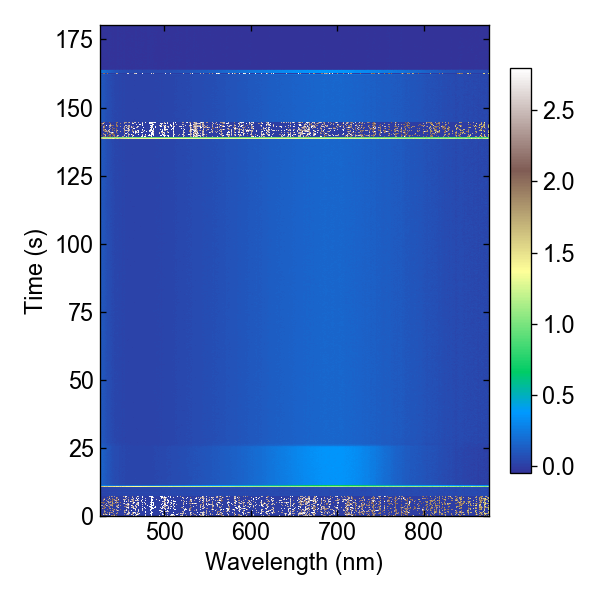

In [8]:
%matplotlib notebook

spec_start = 0; spec_stop = straight_array.shape[0];
straight_crop = straight_array[spec_start:spec_stop,w_start_ind:w_stop_ind]

vmins, vmaxs = np.percentile(straight_crop, (0.5, 99.8))
extent_wli = [waves[w_start_ind], waves[w_stop_ind], 0, (spec_stop-spec_start)*uv_dt]

plt.figure(figsize=(5,5))
plt.imshow(straight_crop,
                origin='lower', aspect='auto',
                vmin=vmins, vmax=vmaxs,
                interpolation='nearest',
                cmap='terrain',
                extent=extent_wli)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Time (s)')
plt.colorbar(fraction=0.047, pad=0.05).ax.tick_params(axis='y', direction='out')

### At what time does the blade pass? Then calculate stop frame from xray stop frame

In [9]:
t_pass = 11.25
t_stop = 30

spec_start = np.round(t_pass / uv_dt).astype(int)
spec_stop = np.round(t_stop / uv_dt).astype(int)

print('Starting row: {}'.format(spec_start))
print('Final row: {}'.format(spec_stop))

Starting row: 55
Final row: 146


## Plot the straight and kicked spectra side-by-side

<IPython.core.display.Javascript object>


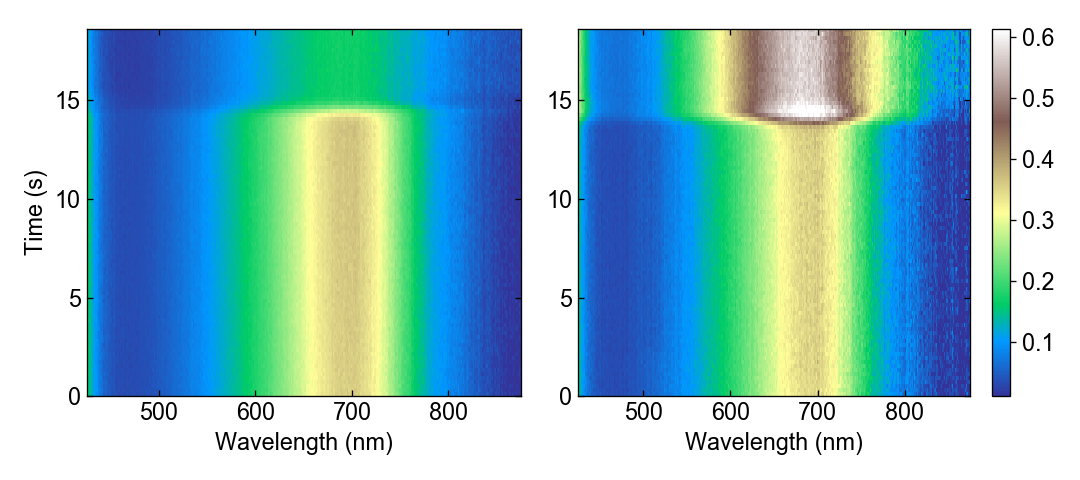

In [24]:
%matplotlib notebook

kick_shift = -1 # Move the kicked spectra "up" (backward) in time by this many rows

straight_crop = straight_array[spec_start:spec_stop,w_start_ind:w_stop_ind].clip(min=0.01)
kicked_crop = kicked_array[spec_start-kick_shift:spec_stop-kick_shift,w_start_ind:w_stop_ind].clip(min=0.01)

vmins, vmaxs = np.percentile(straight_crop, (2.5, 99.8))
vmink, vmaxk = np.percentile(kicked_crop, (2.5, 99.8))
vmin = min(vmins,vmink); vmax = max(vmaxs,vmaxk)

extent_wli = [waves[w_start_ind], waves[w_stop_ind], 0, (spec_stop-spec_start)*uv_dt]

f1 = plt.figure(figsize=(9,4))
ax11 = plt.subplot(121)
plt.imshow(straight_crop,
                origin='lower', aspect='auto',
                vmin=vmin, vmax=vmax,
                interpolation='nearest',
                cmap='terrain',
                extent=extent_wli)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Time (s)')

ax12 = plt.subplot(122, sharey=ax11)
plt.imshow(kicked_crop,
                origin='lower', aspect='auto',
                vmin=vmin, vmax=vmax,
                interpolation='nearest',
                cmap='terrain',
                extent=extent_wli)
plt.xlabel('Wavelength (nm)')
plt.colorbar(fraction=0.047, pad=0.05).ax.tick_params(axis='y', direction='out')
plt.tight_layout()

# uu_file = os.path.join(os.path.split(figfolder)[0],'{}_uu.png'.format(run_name))
plt.savefig(run_name+"_both_channels.png")

## Calculate anisotropy and plot

anisotropy = (A_straight - A_kicked) / (A_straight + A_kicked)

In [12]:
def get_anisotropy(straight_array,kicked_array):
    
    ratio_mat = straight_array/kicked_array
    aniso_mat = 0.5 * (ratio_mat-1)/(ratio_mat+1)
    
    return aniso_mat

<IPython.core.display.Javascript object>


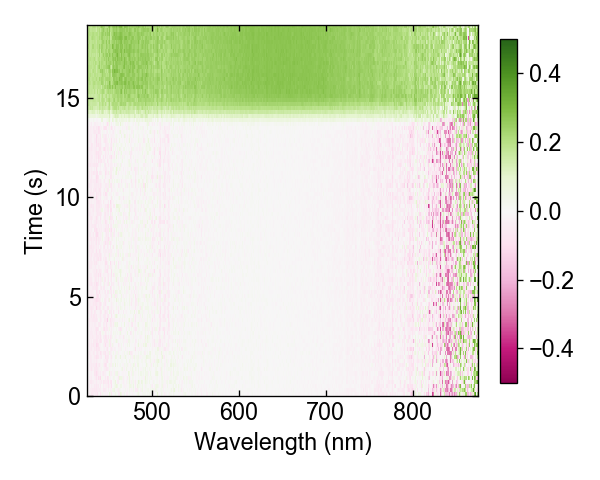

In [15]:
aniso_mat = get_anisotropy(kicked_crop,straight_crop)

plt.figure(figsize=(5,4))
plt.imshow(aniso_mat,
                origin='lower', aspect='auto',
                vmin=-0.5, vmax=0.5,
                interpolation='nearest',
                cmap='PiYG',
                extent=extent_wli)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Time (s)')
plt.colorbar(fraction=0.04, pad=0.05).ax.tick_params(axis='y', direction='out')

plt.savefig(run_name+"_aniso.png")

<IPython.core.display.Javascript object>


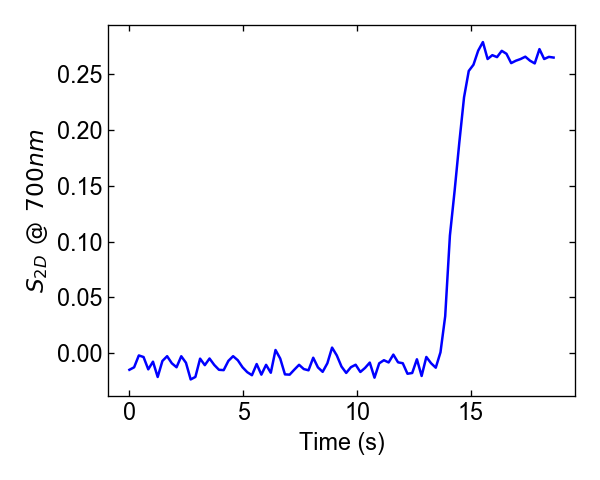

In [25]:
plt.figure(figsize=(5,4))
plt.plot(np.linspace(0,(spec_stop-spec_start)*uv_dt,num=aniso_mat.shape[0]),
         aniso_mat[:,np.where(waves>700)[0][0]-w_start_ind],
         '-b')
plt.xlabel('Time (s)')
plt.ylabel(r'$S_{2D}\:\:@\:\: 700nm$')

plt.savefig(run_name+"_aniso_line.png")

In [ ]:
%matplotlib inline

spec_start_buf = int(spec_start - 2/uv_dt)
straight_movie = straight_array[:,w_start_ind:w_stop_ind].clip(min=0.01)
kicked_movie = kicked_array[:,w_start_ind:w_stop_ind].clip(min=0.01)

for i in range(spec_start_buf, spec_stop):
    
    uvfigpath = os.path.join(figfolder, 'raw_uv', 'abs_{0:04d}.png'.format(i-spec_start_buf))
    print(uvfigpath)
    
    plt.figure(figsize=(4,4))
    
    plt.plot(waves_crop,straight_movie[i,:],
             waves_crop,kicked_movie[i+1,:])
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absorbance')
    ax_temp = plt.gca()
    ax_temp.set_ylim([0,vmax+0.1*vmax])
    
    plt.savefig(uvfigpath, dpi=300, bbox_inches='tight')
    plt.close()

In [ ]:
uvfigwild = uvfigpath[:-8]+"%04d.png"
uvmovieout = os.path.join(figfolder, "uv_movie.mp4")
print(uvfigwild, '\n', uvmovieout)
print('Paste this into cmd and run:')
# Run this to make the movie in command prompt
print("""F:\\GitHub\\ffmpeg\\bin\\ffmpeg.exe -framerate {} -i "{}" -c:v libx264 -r 30 -pix_fmt yuv420p -vf scale=720:-2 -y "{}" """.format(1/uv_dt,uvfigwild,uvmovieout))